# Randomization inference
This notebook illustrates Fisherian randomization inference.

In [2]:
options(digits = 3)
library(ggplot2)
theme_set(theme_bw())
options(repr.plot.width = 6)
options(repr.plot.height = 4)

library(icsw)
library(foreach)




We are going to analyze an experiment in which respondents were randomly assigned to be encouraged to view a particular debate before the U.S. Presidental Election in 1996. This is provided in the `icsw` package.

In [4]:
data(FoxDebate)
head(FoxDebate[sample.int(507, 6),])

,partyid,pnintst,watchnat,educad,readnews,gender,income,white,infopro,support,watchpro,conditn
63,2,4,7,11,7,0,11,1,2,0,0,0
335,3,4,7,11,6,1,10,1,3,0,0,0
179,4,3,6,13,5,0,5.9,1,3,NA,0,0
363,7,3,7,11,7,1,6,1,3,0,0,0
156,5,4,7,9,7,0,7,1,4,0,1,1
319,1,4,7,11,7,1,6,1,4,1,0,0


In [8]:
str(FoxDebate)

'data.frame':	507 obs. of  12 variables:
 $ partyid : num  1 2 7 1 2 2 7 7 6 2 ...
 $ pnintst : num  4 4 4 4 3 2 4 3 3 3 ...
 $ watchnat: num  4 6 7 6 6 6 7 1 6 6 ...
 $ educad  : num  11 9 11 11 11 6 12 12 11 11 ...
 $ readnews: num  2 7 7 7 7 7 7 6 1 6 ...
 $ gender  : num  0 0 1 1 0 0 0 1 1 0 ...
 $ income  : num  5 2 3 7 9 ...
 $ white   : num  1 1 1 1 1 1 0 1 1 0 ...
 $ infopro : num  4 3 3 3 4 4 3 2 3 2 ...
 $ support : num  1 1 NA 1 1 1 0 0 1 1 ...
 $ watchpro: int  0 1 1 1 0 0 0 0 0 0 ...
 $ conditn : int  1 1 1 1 0 1 1 0 0 1 ...


We care about the randomly assigned condition `conditn`. We can look for effects on whether they watched the debate `watchpro` (subjects didn't always "comply") and their support for affirmative action `support`.

Under the sharp null hypothesis of no effect of random assignment on support for affirmation action, we can infer the unobserved values of support under the other treatment -- they are exactly the same.

Let's first just test for whether the random assignment to encouragement to watch the debate affected wathcing the debate.

In [9]:
diff.in.means <- function(z, y) {
    mean(y[z == 1]) - mean(y[z == 0])
}

obs.ate <- diff.in.means(FoxDebate$conditn, FoxDebate$watchpro)
print(obs.ate)

[1] 0.407


Watching the debate occured for 40% more subjects encouraged than not encouraged. This seems large, so unlikely due to chance with 500 observations. But to formally test this, we can do randomization inference: we compare this observed difference in means to the distribution of the difference in means under the null.

We could do this by considering all possible (and equally probable!) treatment assignment vectors (permuations of the observed vector). Or we could just work with a large sample of them:

In [10]:
do.permutations <- function(R = 1000, z, y, fnc = diff.in.means) {
    foreach(i = 1:R, .combine = 'c') %do% {
        zp <- sample(z) # this draws a sample of the same size without replacement (ie a permutation)
        fnc(zp, y) # apply our function
    }
}

In [12]:
do.permutations(10, FoxDebate$conditn, FoxDebate$watchpro)

[1] -0.07411 -0.04253  0.00483  0.05219 -0.01096 -0.03464 -0.05043 -0.01096 -0.01885  0.00483

These all are much smaller than the observed value. We can examine how extreme the observed value really is.

In [13]:
null.ates <- do.permutations(1e4, FoxDebate$conditn, FoxDebate$watchpro)

In [14]:
summary(null.ates)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.1770 -0.0267 -0.0031 -0.0003  0.0285  0.1550 

We plot a histogram of the samples of the differences in means from the null distribution:

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


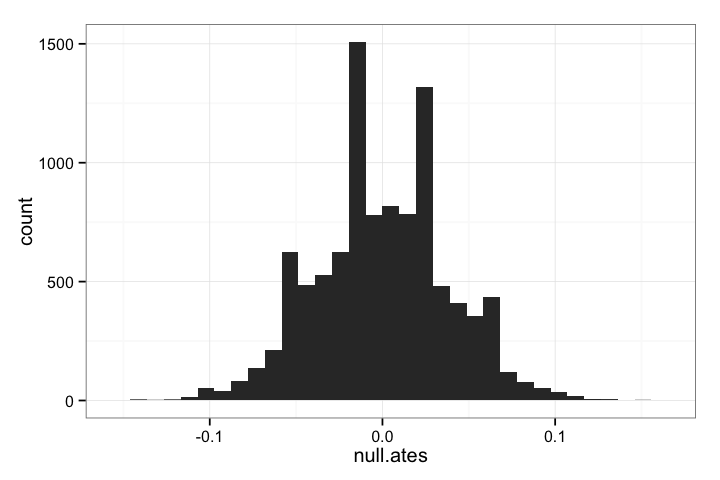

In [57]:
ggplot(
    aes(x = null.ates),
    data = data.frame(null.ates)
) +
geom_histogram() 

And add a line for the observed difference in means, which is clearly extreme.

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


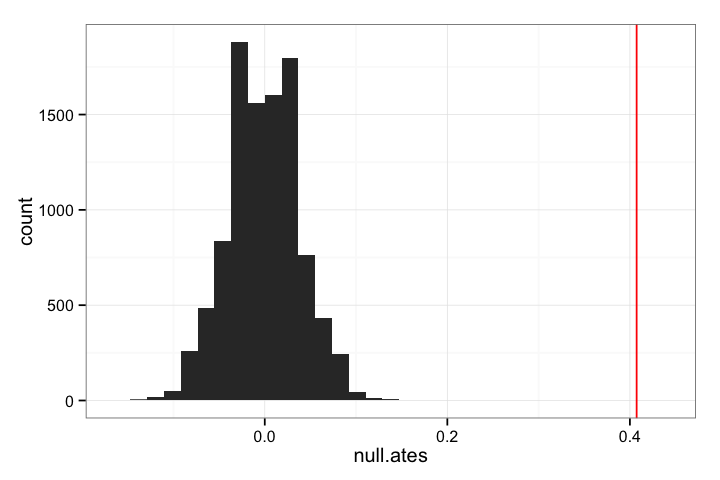

In [59]:
ggplot(
    aes(x = null.ates),
    data = data.frame(null.ates)
) +
geom_histogram() +
geom_vline(xintercept = obs.ate, color = "red")

In [16]:
obs.ate / sd(null.ates)

[1] 10.6

More formally, we can compute a p-value, the probability under the null of observing a test statistics (here, the difference in means) at least as extreme as what we observed.

In [46]:
two.sided.p.value.perm <- function(obs, null.draws) {
    lower.p <- mean(obs > null.draws)
    upper.p <- mean(obs < null.draws)
    2 * min(lower.p, upper.p)
}

In [48]:
two.sided.p.value.perm(obs.ate, null.ates)

[1] 0

In this case, it turns out this is very close to zero, since even with 10,000 draws from the null, none is greater than our observed estimate.

## Exercise: Repeat for the "real" outcome of interest, `support`
